# Foundations of Data Mining: Assignment 3

- Group: 
- Students: Xiaolei Wang (0981285) / Jiyang Li (0975662) 


In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
#HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
InteractiveShell.ast_node_interactivity = "none"

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '88854e9607bcd390ff54881a727f43af'

##  Random Projections with 1-NN (6 points, 3+3)

In [3]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
# Get the predictors X and the labels y
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); 

In [4]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import metrics
from sklearn.decomposition import PCA
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

###  Study the effect on pairwise distances
Evaluate how well the Euclidean distance is preserved by plotting a histogram of the 
values $\phi(p,q) = \frac{\|f(p)-f(q)\|}{\|p-q\|}$ for all pairs of the first 500 images of the MNIST data set. These values should be concentrated around a certain value for fixed $k$. What is this value expressed in terms of $k$ and $d$? Explain your answer.

In [5]:
# generate projection matrix R with dimension k*d
def getR(k, d):
    R = [[0 for i in range(d)] for j in range(k)] 
    for i in range(k):
        for j in range(d):
            R[i][j] = np.random.choice([1/np.sqrt(d),-1/np.sqrt(d)])
            j += 1
        i += 1        
    return np.array(R)

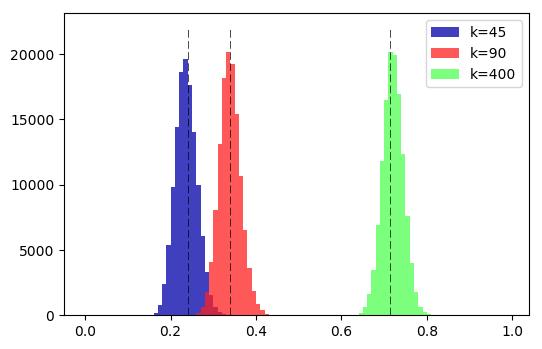

In [6]:
d = X.shape[1] # dimention of original data is 784 
K = [45, 90, 400]
N = 500
X_N = X[0:N] # choose first 500 pictures here

plt.figure()
for k in K:
    R = getR(k,d)

    X_rotate = mat(X_N)*mat(R).T
    phi = []

    for i in range(N):
        for j in range(i+1,N):
            dif_f = np.linalg.norm(X_rotate[i] - X_rotate[j])
            dif_p = np.linalg.norm(X_N[i] - X_N[j])
            phi.append(dif_f / dif_p)
    
    ratio = np.sqrt(k/d)
    bins = np.arange(0, 1, 0.01)
    plt.hist(pd.Series(np.array(phi)), bins, label='k=%d' % k, alpha=0.75)
    plt.plot([ratio,ratio],[0,22000],'k--')
plt.legend()
plt.show()

**Solution**

The values $\phi(p,q) = \frac{\|f(p)-f(q)\|}{\|p-q\|}$ for all pairs p and q are centered at $\sqrt \frac {k}{d}$.

Prove: Let $\bf r_i$ be $i^{th}$ row of $\bf R$ and $p-q=\lambda$ . $$\|f(p)-f(q)\|^2=\sum_{i=1}^{k}\|{\bf r_i} (p-q)\|^2=\sum_{i=1}^{k}\|{\bf r_i}\lambda\|^2$$since $\bf r_{ij}^2=\frac{1}{d}$. 
$$\mathbb{E}[\|f(p)-f(q)\|^2]=\sum_{i=1}^{k}\mathbb{E}[\|{\bf r_i}\lambda\|^2]=\sum_{i=1}^{k}\mathbb{E}[\sum_{j=1}^{d}({\bf r_{ij}}\lambda_j)^2]=\sum_{i=1}^{k}\mathbb{E}[\frac{1}{d}\sum_{j=1}^{d}(\lambda_j)^2]=\frac{k}{d}\|\lambda\|^2$$ 
$$\mathbb{E}[\|p-q\|^2]=\mathbb{E}[\|\lambda\|^2]=\|\lambda\|^2$$

$$\frac{\mathbb{E}[\|f(p)-f(q)\|^2]}{\mathbb{E}[\|p-q\|^2]}=\frac{k}{d}$$

So, $$\frac{\mathbb{E}\|f(p)-f(q)\|]}{\mathbb{E}[\|p-q\|]}=\sqrt\frac{k}{d}$$ The ratio of projected length and original length are centered in the mean value $\sqrt\frac{k}{d}$.


### Study the effect on classification
Compare the performance of a $1$-NN classifier with and without random projection. Report multi-class confusion matrix, precision and recall for each class with and without projection and for each value of $k$. Evaluate your findings with respect to the use of random projections and classification.

In [7]:
y_N = y[0:N]
precision = []
recall = []
X_train, X_test, y_train, y_test = train_test_split(X_N, y_N, random_state=0,stratify=y_N)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm =  confusion_matrix(y_test, y_pred)
print('confusion_matrix for data without projection is:')
print(cm)
precision.append(precision_score(y_test, y_pred, average=None))
recall.append(recall_score(y_test, y_pred, average=None))

pre = []
rec = []
for k in K:
    
    R = getR(k,d)
    X_rotate = mat(X_N)*mat(R).T
    X_train, X_test, y_train, y_test = train_test_split(X_rotate, y_N, random_state=0,stratify=y_N)
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    cm =  confusion_matrix(y_test, y_pred)
    print('Confusion matrix for projection with k=%s' % k)
    print(cm)
    pre.append(precision_score(y_test, y_pred, average=None))
    rec.append(recall_score(y_test, y_pred, average=None))

confusion_matrix for data without projection is:
[[13  0  0  0  0  0  0  0  0  0]
 [ 0 14  1  0  0  0  0  1  0  0]
 [ 0  4  9  0  0  0  0  0  0  0]
 [ 0  0  1 11  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  2]
 [ 0  0  0  0  0  9  1  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  0  1  0  0  0  0 11  0  1]
 [ 0  0  0  1  0  1  0  0  8  0]
 [ 0  0  0  1  0  1  0  0  0 12]]
Confusion matrix for projection with k=45
[[11  1  0  0  0  1  0  0  0  0]
 [ 0 15  0  0  0  0  0  1  0  0]
 [ 0  4  6  0  0  0  1  1  1  0]
 [ 0  0  1  9  0  0  1  1  0  0]
 [ 0  0  0  0 11  0  0  1  0  1]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  1  0 10  0  0  0]
 [ 0  0  1  0  0  0  0 11  0  1]
 [ 0  0  0  3  0  0  1  0  6  0]
 [ 0  0  0  0  3  1  0  3  0  7]]
Confusion matrix for projection with k=90
[[13  0  0  0  0  0  0  0  0  0]
 [ 0 14  1  0  0  0  0  0  0  1]
 [ 0  2  7  0  0  0  1  1  1  1]
 [ 0  0  0 10  1  1  0  0  0  0]
 [ 0  0  0  0  9  0  0  1  0  3]
 [ 0  0  0  1  0  7  2  0  0  0]
 [ 0  1

In [8]:
pd.set_option('display.max_columns', None)
df_1 = pd.DataFrame(pre,index=K)
df_0 = pd.DataFrame(precision,index=['Unprojected'])
df_pre = df_0.append(df_1)
print('Precision Score')
display(df_pre)

pd.set_option('display.max_columns', None)
df_1 = pd.DataFrame(rec,index=K)
df_0 = pd.DataFrame(recall,index=['Unprojected'])
df_rec = df_0.append(df_1)
print('Recall Score')
display(df_rec)


Precision Score


,0,1,2,3,4,5,6,7,8,9
Unprojected,1.00,0.78,0.75,0.85,1.00,0.82,0.92,0.92,1.0,0.80
45,0.71,0.82,0.88,0.79,0.93,1.00,0.91,0.79,1.0,0.77
90,1.00,0.78,1.00,0.69,1.00,0.70,0.92,0.92,0.8,0.71
400,1.00,0.78,0.80,0.79,1.00,0.82,0.92,0.85,1.0,0.73


Recall Score


,0,1,2,3,4,5,6,7,8,9
Unprojected,1.00,0.88,0.69,0.92,0.85,0.9,1.00,0.85,0.8,0.86
45,0.92,0.88,0.54,0.92,1.00,0.8,0.91,0.85,0.9,0.71
90,0.92,0.88,0.62,0.92,0.77,0.7,1.00,0.85,0.8,0.86
400,1.00,0.88,0.62,0.92,0.85,0.9,1.00,0.85,0.8,0.79


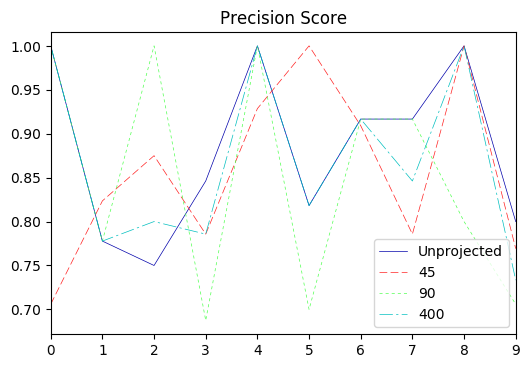

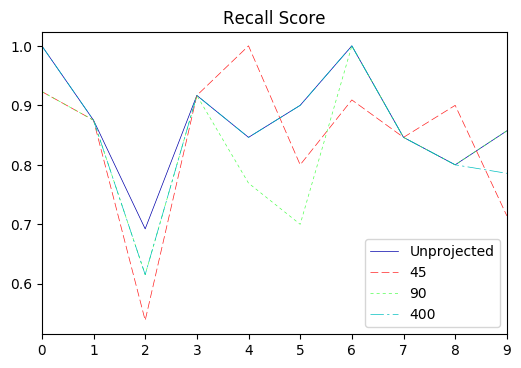

In [9]:
df_pre.T.plot(rot=1,title='Precision Score')
df_rec.T.plot(rot=1,title='Recall Score')

In [10]:
print(14/16)

0.875


**Solution**

From Confusion matrix we could see how many correct and fault predictions are and how they distribute in each class. Correct predictions are located in diagonal of the table and errors are outside diagonal. Calculate diagonal value over all values in column we get the Precision Score and get Recall Score the same way by calculating in each row. Then we could get 10 Precision Scores and 10 Recall Scores for each class.

From DataFrames and Plots we can see that the scores of 1-NN classifier for unprojected data are relative high but not always the highest. And the scores for data when projected with k=45 is relative low but not always the lowest either, which means when we use 1-NN classifier on random projected data, the scores won't be infuenced much compared to the unprojected one especially for k=400 (the line of k=400 is the one similar to the line of unprojected data most). When we compared Precision with Recall we could see that Precision might be infuenced more by the dimension of data.

So we can conclude that the behaviors of 1-NN classifier for data with and without projection are similar and the influence would decrease when k goes closer to original dimension.  

## PCA of a handwritten digits (7 points, 3+2+2)

In [8]:
# build a list of figures on a 5x5 grid for plotting
def buildFigure5x5(fig, subfiglist):
    
    for i in range(0,25):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(5,5,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

### Step (a)
Generate a scatter plot of the data in the space spanned by the first two principal components of PCA. Reconstruct $25$ points on a $5 \times 5$ grid in this space that cover the variation of the data. Render each point as an image. Arrange the images in a $5 \times 5$ grid.


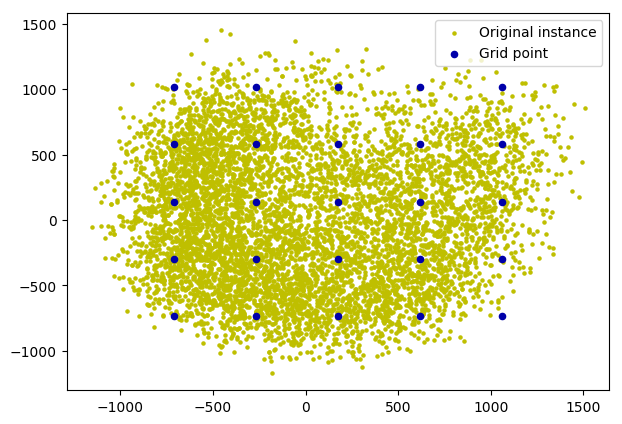

In [9]:
X_4 = X[y==4]
y_4 = y[y==4]
X_pca = PCA(n_components=2).fit_transform(X_4)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=5, c='y', label='Original instance')

max0,max1 = np.amax(X_pca, axis=0)
min0,min1 = np.amin(X_pca, axis=0)

grid0 = np.arange(min0,max0,(max0-min0)/6)
grid1 = np.arange(min1,max1,(max1-min1)/6)

# Arrange the grid point from left to right, from top to down
grid_points = []
for i in reversed(grid1[1:6]):
    for j in grid0[1:6]:
        pair = [j, i]
        grid_points.append(pair)

grid = np.array(grid_points)
plt.scatter(grid[:,0], grid[:,1], s=20, marker='o', label='Grid point')

plt.legend()
plt.show()

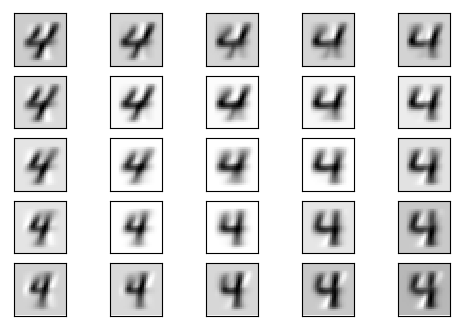

In [7]:
# Render each point as an image
pca = PCA(n_components=2).fit(X_4)
v = pca.components_
mean = np.mean(X_4,axis=0)
grid_img = []
for i in range(25):
    grid_img.append(mean + grid[i][0]*v[0] + grid[i][1]*v[1])

buildFigure5x5(plt.figure(2), grid_img)
plt.show()


In [13]:
print(np.linalg.norm(X_4[0]-X_4[1]))
print(np.linalg.norm(X_pca[0]-X_pca[1]))

2171.07
1211.18220523


### Step (b) 
For each of the reconstructed points, find the original instance that is closest to it in the projection on the first two components (measured using Euclidean distance). Render the instances arranged in a $5 \times 5$ grid such that their position matches the rendering in (a).


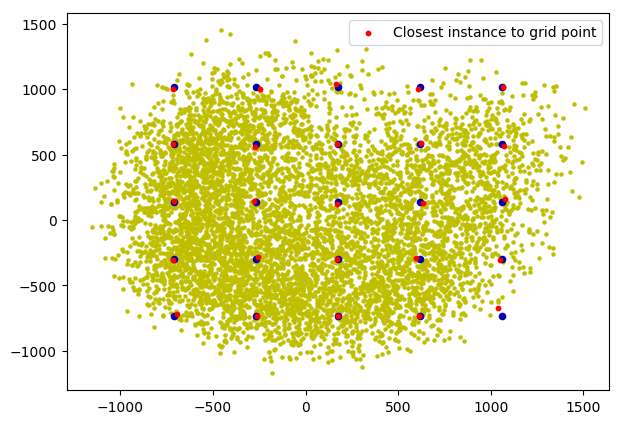

In [14]:
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=5, c='y')
plt.scatter(grid[:,0], grid[:,1], s=20, marker='o')

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(X_pca)
dit,ind = neigh.kneighbors(grid)
plt.scatter(X_pca[ind,0],X_pca[ind,1],c='r', s=10, label='Closest instance to grid point')
plt.legend()
plt.show()

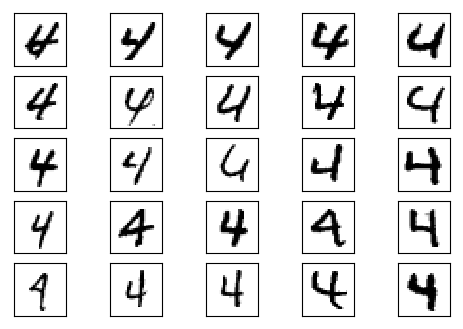

In [15]:
buildFigure5x5(plt.figure(2), X_4[ind])
plt.show()

### Step (c)
Render the mean and the first two principal components as images. What is your interpretation of the first two components, i.e., which aspect of the data do they capture? Justify your interpretation, also using your results of Steps (a) and (b).

In [16]:
def plt_component(fig,title):
    pixels = np.array(fig, dtype='float')
    pixels = pixels.reshape((28, 28))
    imgplot =plt.imshow(pixels, cmap='gray_r')
    plt.title(title)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    return

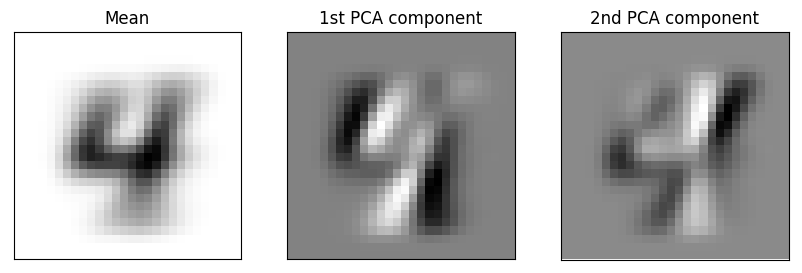

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt_component(np.mean(X_4,axis=0),'Mean')

pca = PCA(n_components=2).fit(X_4)
plt.subplot(1,3,2)
plt_component(pca.components_[0],'1st PCA component')
plt.subplot(1,3,3)
plt_component(pca.components_[1],'2nd PCA component')

## Projection onto a hyperplane (4 points)
Let $F$ be a $k$-dimensional hyperplane given by the parametric representation
$$ g(\lambda) = \mu + {\bf V} \lambda,$$
where $\mu \in \mathbb{R}^d$ and the columns of $\bf V$ are pairwise orthogonal and normal vectors $\bf v_1,\dots,v_k \in \mathbb{R}^d$.
Let $f:\mathbb{R}^d\rightarrow F$ be the projection that maps every point ${\bf p} \in \mathbb{R}^d$ to its nearest point on $F$ (where distances are measured using the Euclidean distance). We can write the projection into the subspace spanned by $\bf v_1,\dots,\bf v_k$ as follows 
$$f({\bf p}) = {\bf V}^T ({\bf p}-\mu).$$

Prove that for any ${\bf p,q} \in \mathbb{R}^d$, it holds that
$$ \|f({\bf p})-f({\bf q})\| \leq \|{\bf p-q}\|. $$

(Hint: Assume first that $\mu=0$. Rewrite $f$ using a rotation followed by an orthogonal projection. What happens to the distance in each step? Generalize to arbitrary $\mu$.)

(1) When $\mu=0$, we get: 
$$ g(\lambda) = {\bf V} \lambda $$ and:
$$ f({\bf p}) = {\bf V}^T {\bf p}$$
Because $V$ is a matrix containing orthogonal and normal vectors, so we could rewrite $f$ as:
$$ f({\bf p}) = PM{\bf p} ,$$ where $P$ is the orthogonal projection onto first k coordinates, and $M$ is the rotation with each pair of row vectors is orthogonal and each row vector has unit length. Because $ M $ purly represents a rotation of the original data space, so length of vector $(\bf p -\bf q)$ will not change after rotation; but after the step of orthogonal projection, length of $f({\bf p})- f({\bf q})$ will decrease, because vector $(\bf p -\bf q)$ has an angle with every dimension. Imagine that we don't consider rotation, we could write length of vector $(\bf p -\bf q)$ as $\| \bf p -\bf q \| = \sqrt {\sum_{i=1}^{d} (\bf p - \bf q)_i}$, then if we eliminate the $d_{th}$ dimension, this is an orthogonal projection process and the length of vector in new space will be $\sqrt {\sum_{i=1}^{d-1} (\bf p - \bf q)_i}$. So the length of vector is reduced every time we do orthogonal projection. Therefore $ \|f({\bf p})-f({\bf q})\| \leq \|{\bf p-q}\| $ is true.

$$ $$


We can also prove by Cauchy–Schwarz inequality:
$$\| f({\bf p})- f({\bf q})\|^2  = \|{\bf V}^T* ({\bf p}-{\bf q})\|^2=\langle {\bf V}^T* ({\bf p}-{\bf q}),{\bf V}^T* ({\bf p}-{\bf q})\rangle=\\ \langle{\bf V}^T* ({\bf p}-{\bf q}), ({\bf p}-{\bf q})\rangle \leq \| {\bf V}^T* ({\bf p}-{\bf q}) \| \| {\bf p}-{\bf q} \| = \| f({\bf p})- f({\bf q})\| \| {\bf p}-{\bf q} \|.$$
so we got: $$\|f({\bf p})- f({\bf q})\|\leq \|{\bf p}-{\bf q}\|$$

(2) When $\mu \neq 0$, $ f({\bf p}) = {\bf V}^T ({\bf p}-\mu).$

$$ \| f({\bf p})- f({\bf q})\|=\|{\bf V}^T* ({\bf p}-\mu-{\bf q}+\mu)\|=\|{\bf V}^T* ({\bf p}-{\bf q})\| $$

Then the generalization is the same as when $\mu=0$

## Locality-sensitive hashing (3 points, 1+2)

$H$ is a family of $(d_1,d_2,p_1,p_2)$-locality-sensitive hash functions if it holds that
\begin{align}
\text{if}\quad d({\bf p,q})\leq d_1 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \geq p_1 \quad \\
\text{if}\quad d({\bf p,q})\geq d_2 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \leq p_2 \quad
\end{align}

### Case: $p_2=0$
Assume that $p_2=0$ and assume we have a total numer of $m$ hash
functions from this family available.  Which combination of AND-constructions
and OR-constructions should we use to amplify the hash family?


Solution:



### Case: $p_2=\frac{1}{n}$
Now assume that $p_2=\frac{1}{n}$ and assume we have $n$ data points $\bf P$
which are stored in a hash table using a randomly chosen function $h$ from $H$.
Given a query point $\bf q$, we retrieve the points in the hash bucket with index $h(\bf q)$ to search 
for a point which has small distance to $\bf q$. 
Let $X$ be a random variable that is equal to the size of the set 

\begin{align}
\left\{{\bf p \in P}\,:\, h({\bf p})=h({\bf q}) \,\wedge\, d({\bf p,q}) \geq d_2\right\}\
\end{align}

which consists of the false positives of this query.

Derive an upper bound on the expected number of false-positives $\mathbb{E}\left[ X \right]$ using $p_2$. Explain each step of your derivation.